In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
library("clustree")

Loading required package: ggraph



In [4]:

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [5]:
normal.data <- Read10X(data.dir = "./filtered_feature_MGUSPC_2")
normal <- CreateSeuratObject(counts = normal.data, project = "MGUSPC2", min.cells = 3, min.features = 100)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [6]:
normal

An object of class Seurat 
12870 features across 2817 samples within 1 assay 
Active assay: RNA (12870 features, 0 variable features)

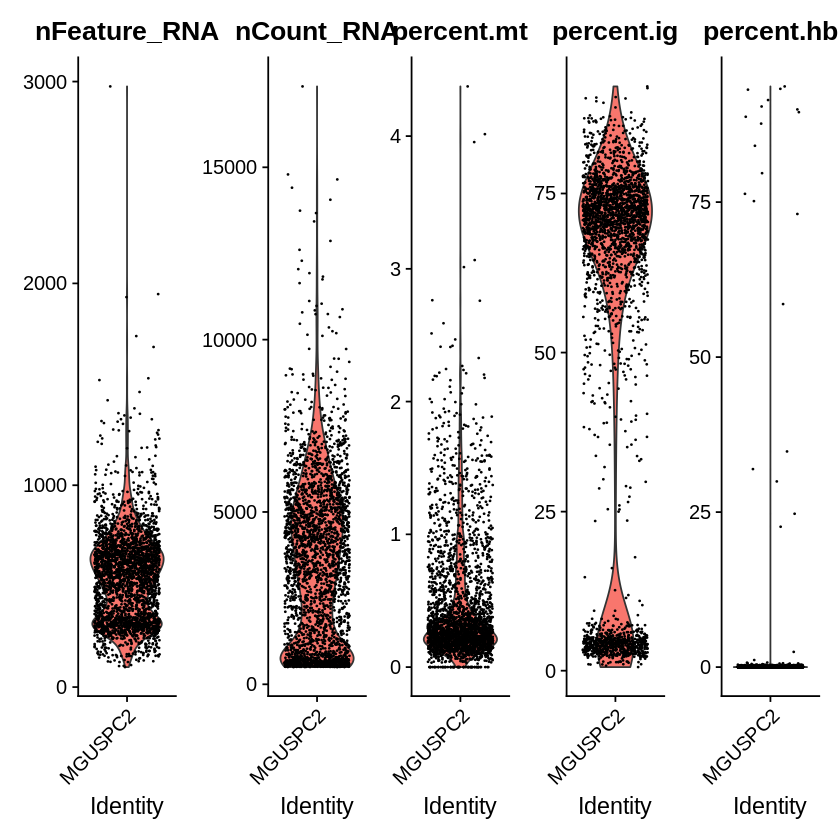

In [7]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [8]:
summary(normal@meta.data)

   orig.ident     nCount_RNA     nFeature_RNA      percent.mt    
 MGUSPC2:2817   Min.   :  499   Min.   :  99.0   Min.   :0.0000  
                1st Qu.: 1185   1st Qu.: 345.0   1st Qu.:0.1867  
                Median : 3521   Median : 551.0   Median :0.2797  
                Mean   : 3504   Mean   : 542.8   Mean   :0.4509  
                3rd Qu.: 5118   3rd Qu.: 675.0   3rd Qu.:0.5319  
                Max.   :17347   Max.   :2976.0   Max.   :4.3742  
   percent.ig       percent.hb      
 Min.   : 0.566   Min.   : 0.00000  
 1st Qu.:14.693   1st Qu.: 0.00000  
 Median :69.314   Median : 0.02323  
 Mean   :53.745   Mean   : 0.54603  
 3rd Qu.:73.964   3rd Qu.: 0.05709  
 Max.   :91.828   Max.   :93.65892  

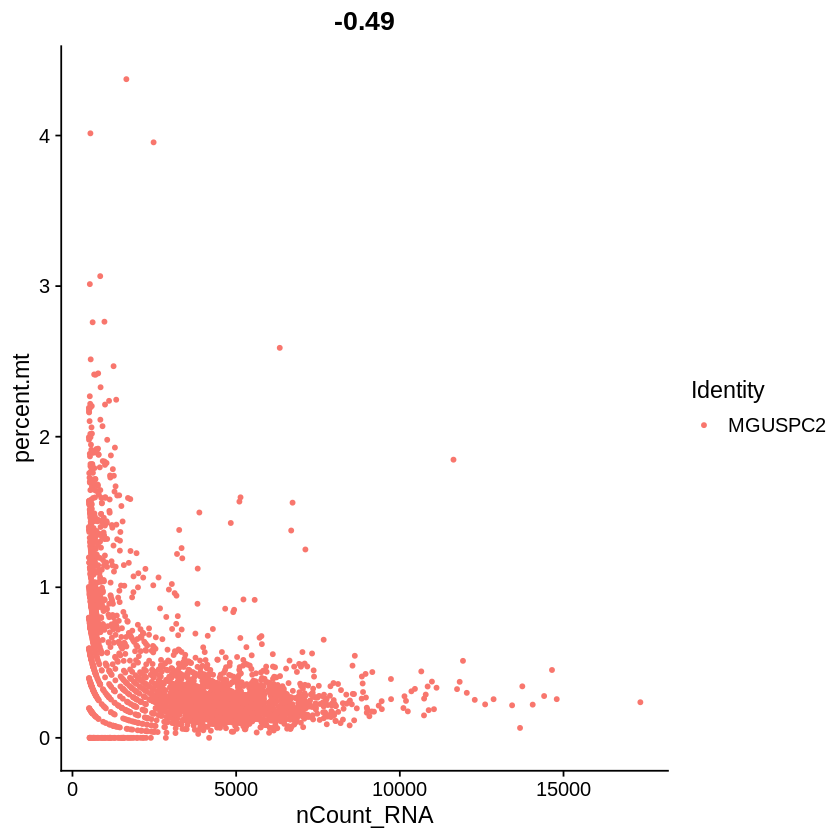

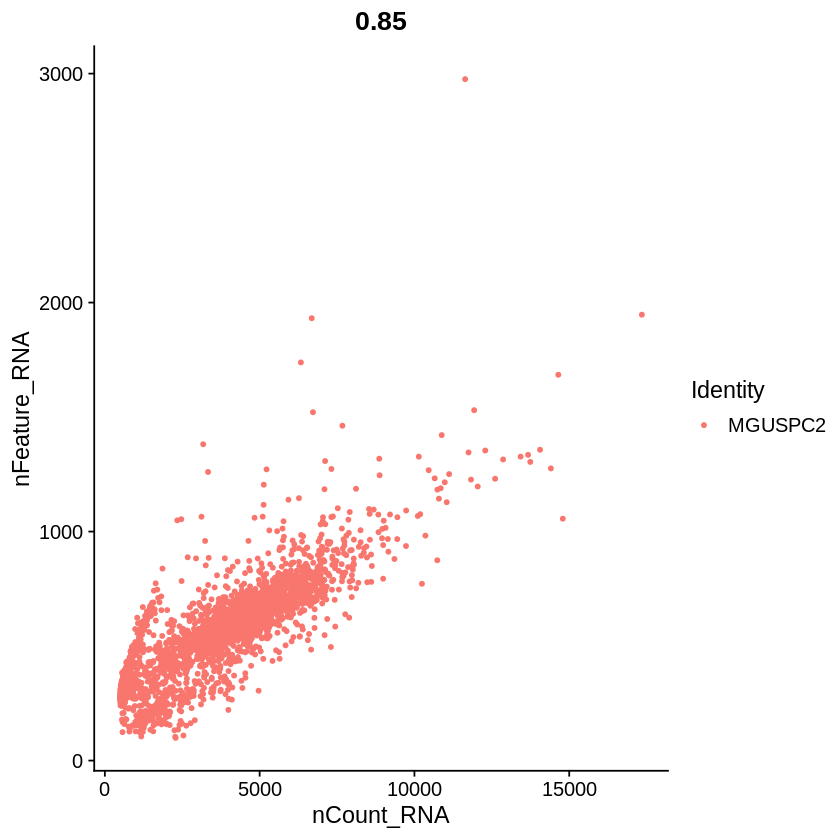

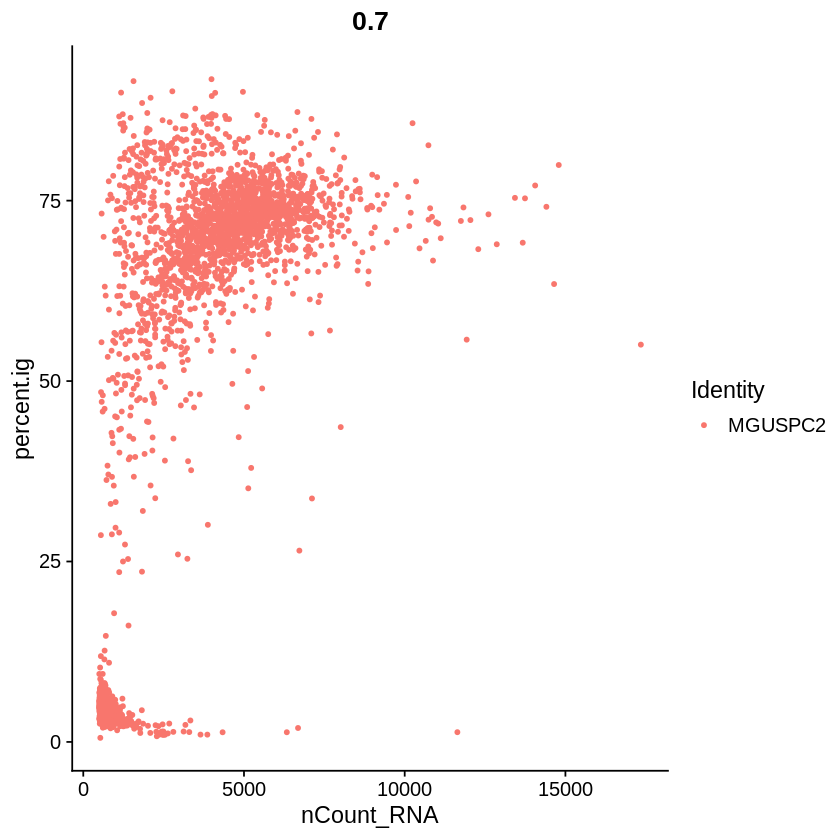

In [9]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [10]:
normal <- subset(normal, subset = nFeature_RNA > 200 & nFeature_RNA < 1500 & percent.mt < 5& percent.hb<1)
normal

An object of class Seurat 
12870 features across 2720 samples within 1 assay 
Active assay: RNA (12870 features, 0 variable features)

In [11]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


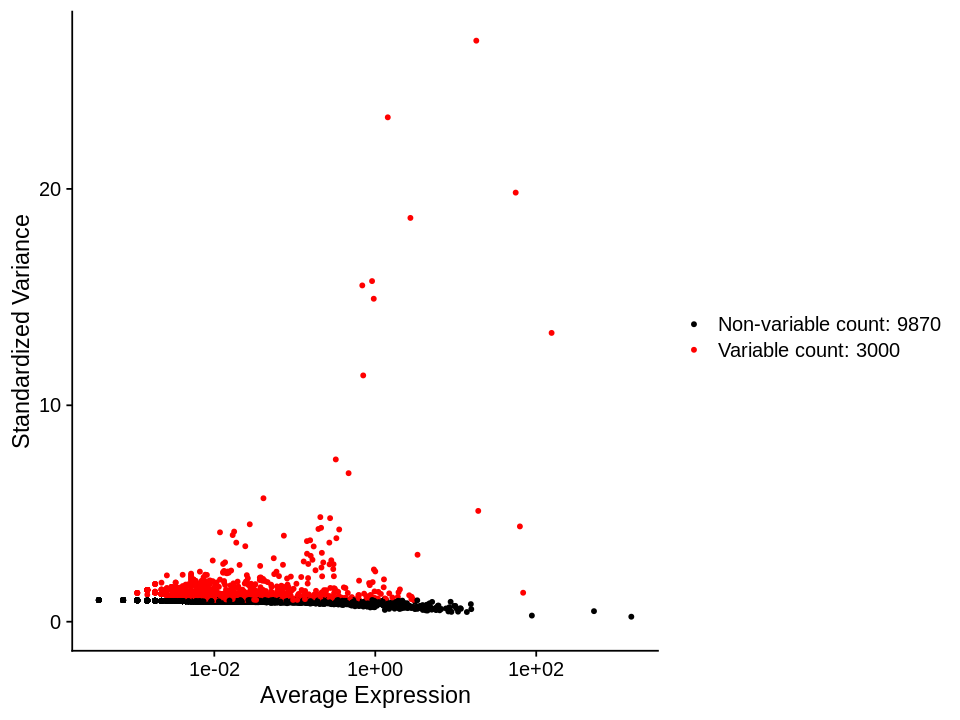

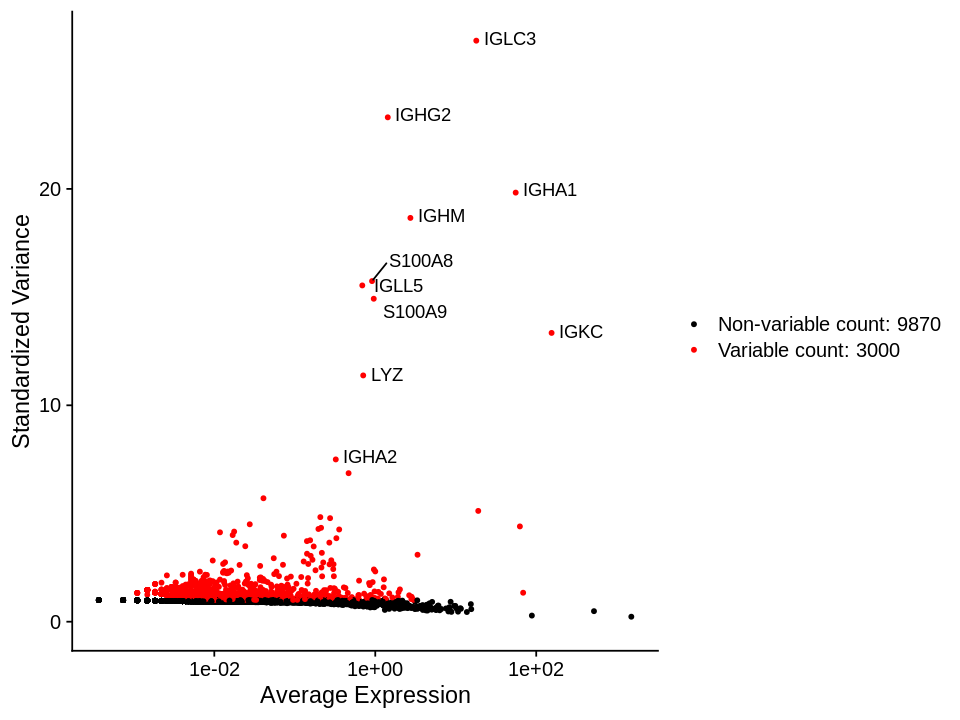

In [101]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [102]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [103]:
length(VariableFeatures(object = normal))

[1] 3000

In [104]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  TMSB4X, TYROBP, S100A4, AIF1, LYZ, FCN1, TMSB10, CST3, ACTB, LST1 
	   CD52, FCER1G, S100A9, S100A8, SH3BGRL3, HLA-DRB1, S100A11, S100A6, HLA-DRA, SERPINA1 
	   IFITM3, CD14, S100A10, S100A12, CORO1A, HCST, COTL1, ITGB2, LGALS1, TSPO 
Negative:  FKBP11, IGHG1, MZB1, IGHG4, DERL3, IGLC3, JCHAIN, CCND1, HERPUD1, SEC11C 
	   PRDX4, RP5-887A10.1, VPREB3, HSP90B1, MDK, FRZB, JSRP1, CADM1, CD79A, DKK1 
	   MANF, AC006129.2, FCRLA, HSPA5, LRRC16A, JUN, LMAN1, TMEM205, ITM2B, PAIP2B 
PC_ 2 
Positive:  FOS, LYZ, FCN1, CST3, AIF1, S100A9, TYROBP, S100A8, CTSS, LST1 
	   FCER1G, SERPINA1, CFD, IGHG4, CD14, IFITM3, S100A12, DUSP1, TYMP, MNDA 
	   IGLC3, IGHG1, FTH1, RP11-1143G9.4, RETN, FOLR3, DUSP6, CSTA, CLEC7A, JCHAIN 
Negative:  IL32, CCL5, NKG7, CD3D, GNLY, GZMH, GZMA, CD3G, CD2, TRBC1 
	   CD3E, CD52, TRAC, KLRB1, CST7, TRBC2, AC092580.4, TMSB4X, KLRD1, CTSW 
	   CCL4, LTB, GIMAP7, GZMM, GZMB, HCST, LCK, PRF1, PTPRC, RARRES3 
PC_ 3 
Positive:  S100A9, S100A8, FCN1, LYZ, TYR

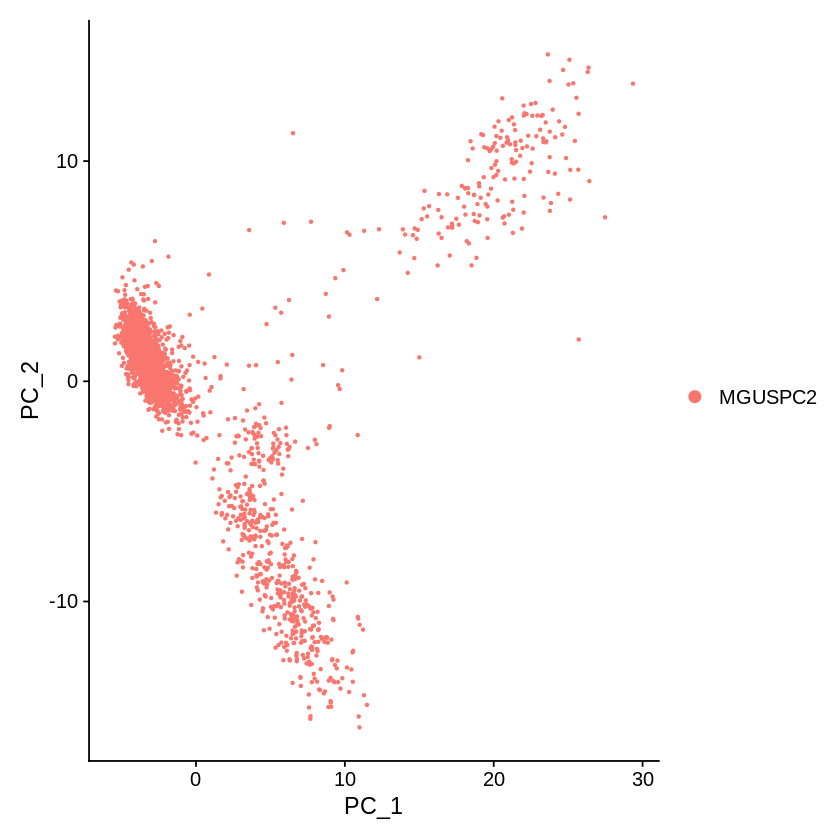

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 44560 rows containing missing values (geom_point).”


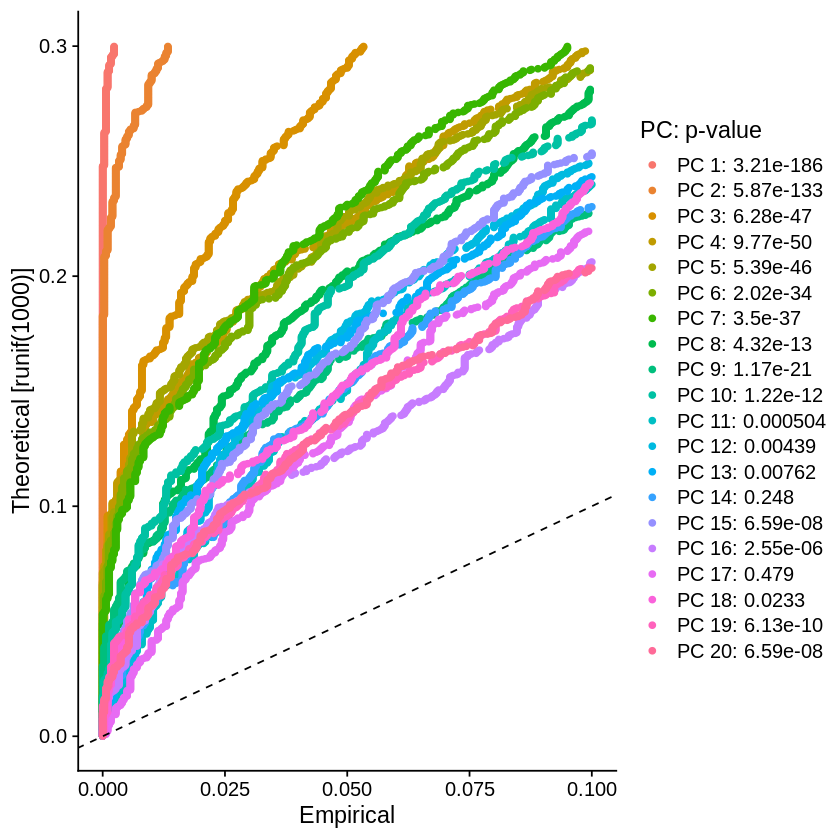

In [18]:
JackStrawPlot(normal, dims = 1:20)

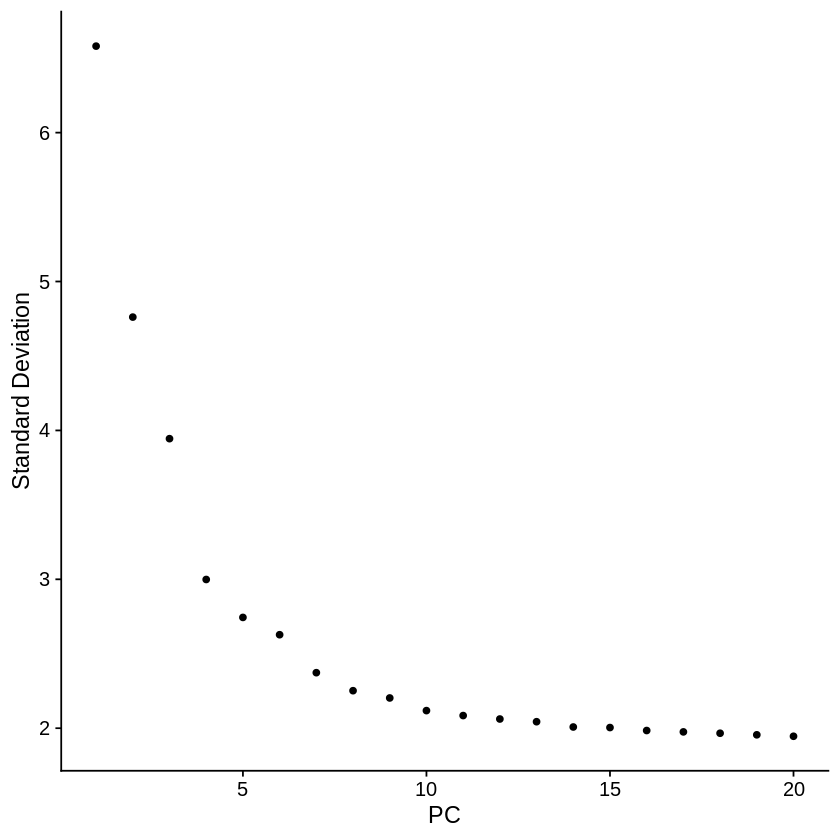

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:8)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:57:10 UMAP embedding parameters a = 0.9922 b = 1.112

13:57:10 Read 2720 rows and found 8 numeric columns

13:57:10 Using Annoy for neighbor search, n_neighbors = 30

13:57:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:57:10 Writing NN index file to temp file /tmp/RtmpX3lwol/file82c5fe1d88ab

13:57:10 Searching Annoy index using 1 thread, search_k = 3000

13:57:10 Annoy recall = 100%

13:57:11 Commencing smooth kNN distance calibration using 1 thread

13:57:11 Initializing from

In [21]:
options(repr.plot.height=8,repr.plot.width=8)

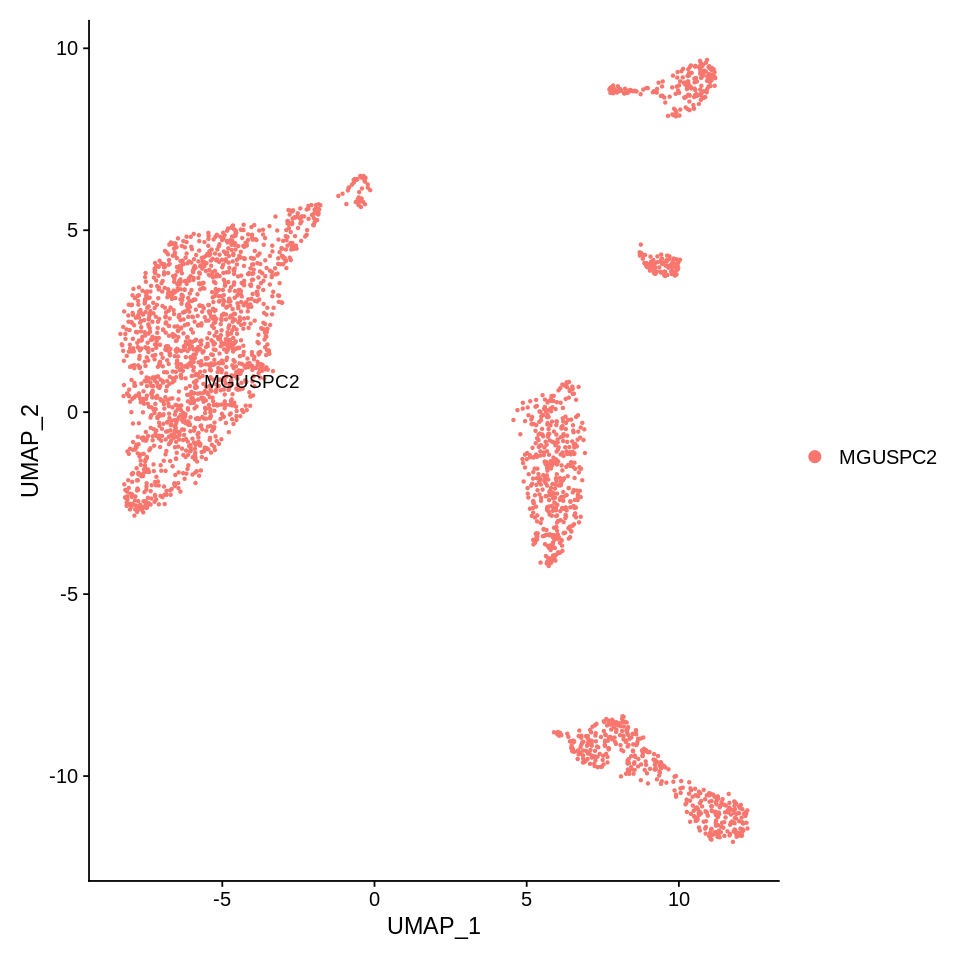

In [22]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


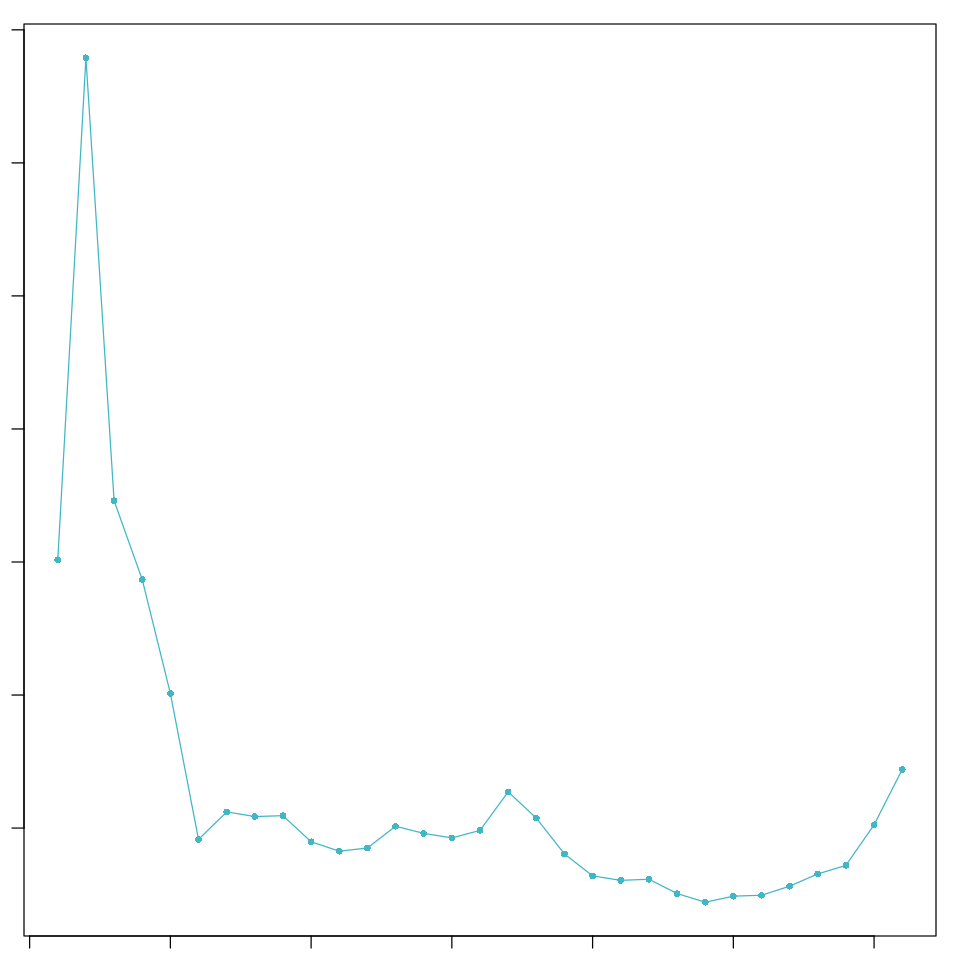

In [23]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:8, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [24]:
normal <- doubletFinder_v3(normal, PCs = 1:8, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 907 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [25]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

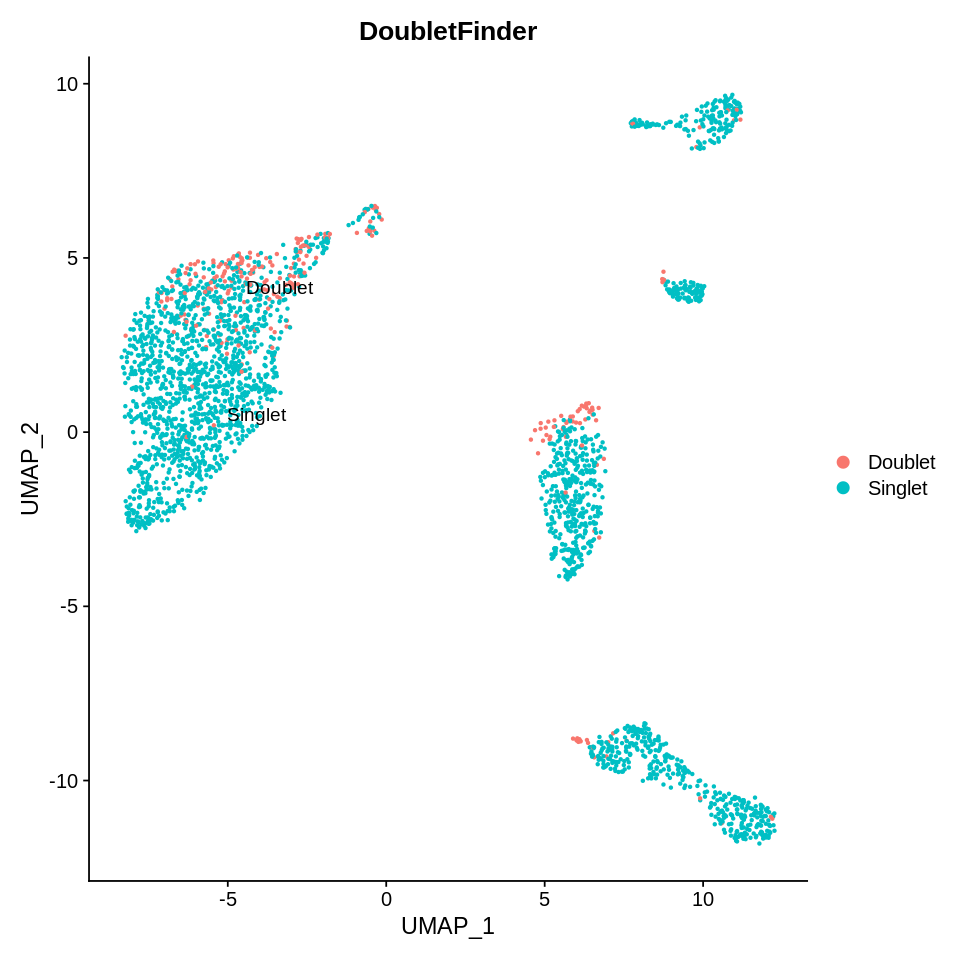

In [26]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [27]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [28]:
normal
normal2

An object of class Seurat 
12870 features across 2720 samples within 1 assay 
Active assay: RNA (12870 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
12870 features across 2448 samples within 1 assay 
Active assay: RNA (12870 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 22 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 22 rows containing missing values (geom_point).”


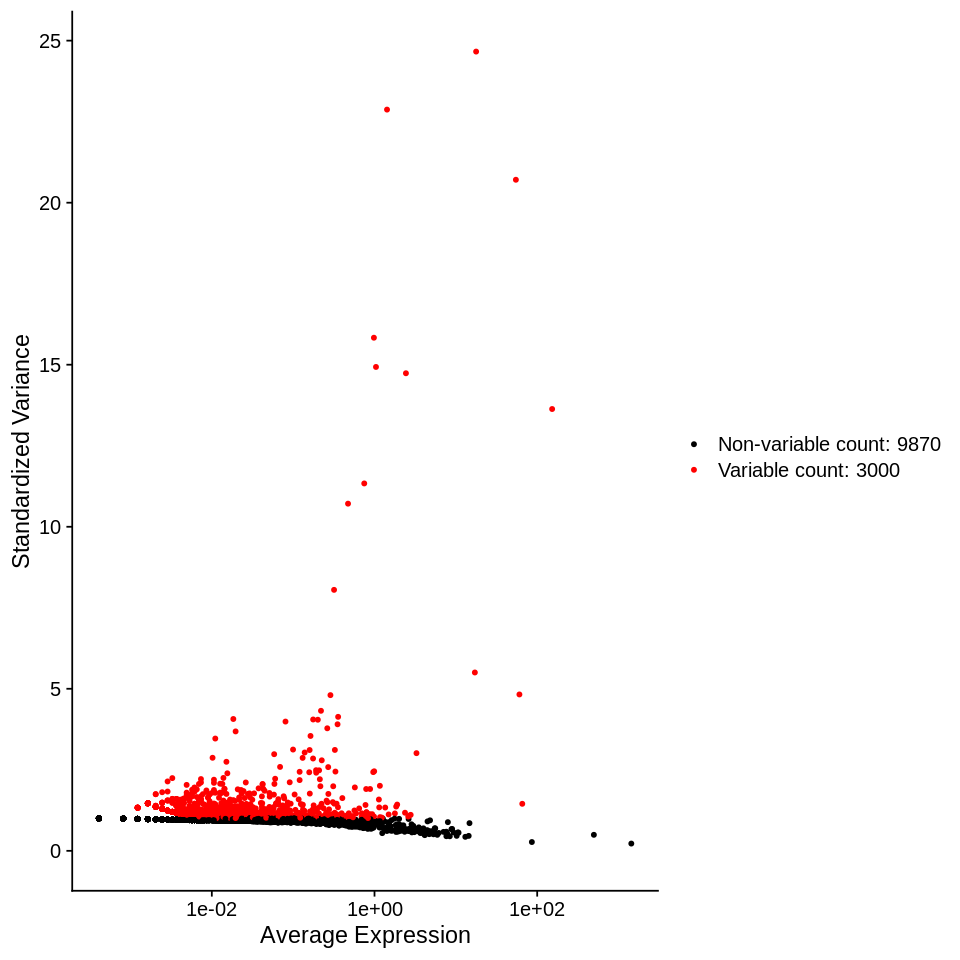

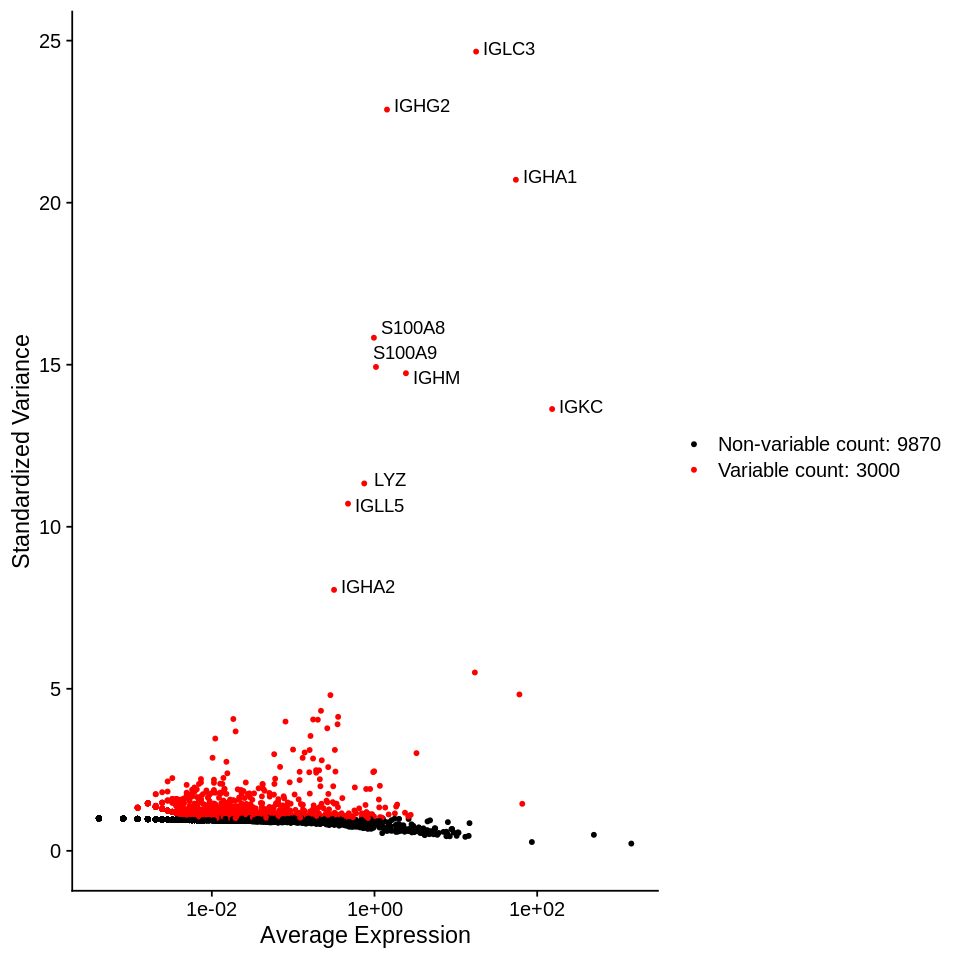

In [29]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [30]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [31]:
length(VariableFeatures(object = normal2))

[1] 3000

In [32]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  TYROBP, TMSB4X, S100A4, AIF1, FCN1, LYZ, CST3, LST1, FCER1G, ACTB 
	   S100A9, CD52, S100A8, SH3BGRL3, S100A11, S100A6, HLA-DRB1, HLA-DRA, SERPINA1, IFITM3 
	   CD14, S100A12, S100A10, COTL1, SAT1, LGALS1, MS4A7, CFD, TSPO, MNDA 
Negative:  FKBP11, MZB1, IGHG1, DERL3, IGHG4, JCHAIN, IGLC3, CCND1, SEC11C, HERPUD1 
	   PRDX4, RP5-887A10.1, HSP90B1, VPREB3, MDK, FRZB, JSRP1, SDF2L1, CADM1, CD79A 
	   DKK1, MANF, SDC1, DUSP22, HSPA5, AC006129.2, JUN, FCRLA, LRRC16A, PRDM1 
PC_ 2 
Positive:  FOS, FCN1, LYZ, CST3, AIF1, S100A9, TYROBP, CTSS, S100A8, LST1 
	   FCER1G, IGHG4, CFD, SERPINA1, IGHG1, IGLC3, CD14, IFITM3, DUSP1, JCHAIN 
	   S100A12, TYMP, DERL3, TIMP1, MNDA, MZB1, FKBP11, DUSP6, CCND1, RP11-1143G9.4 
Negative:  IL32, CCL5, NKG7, CD3D, GNLY, GZMH, CD52, GZMA, CD3G, TRBC1 
	   CD2, TRAC, CD3E, KLRB1, CST7, TMSB4X, TRBC2, AC092580.4, KLRD1, CTSW 
	   CCL4, LTB, GIMAP7, GZMB, HCST, GZMM, PTPRC, PRF1, C12orf75, LCK 
PC_ 3 
Positive:  STMN1, KIAA0101, VPREB3, CCND1, TY

In [33]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 46380 rows containing missing values (geom_point).”


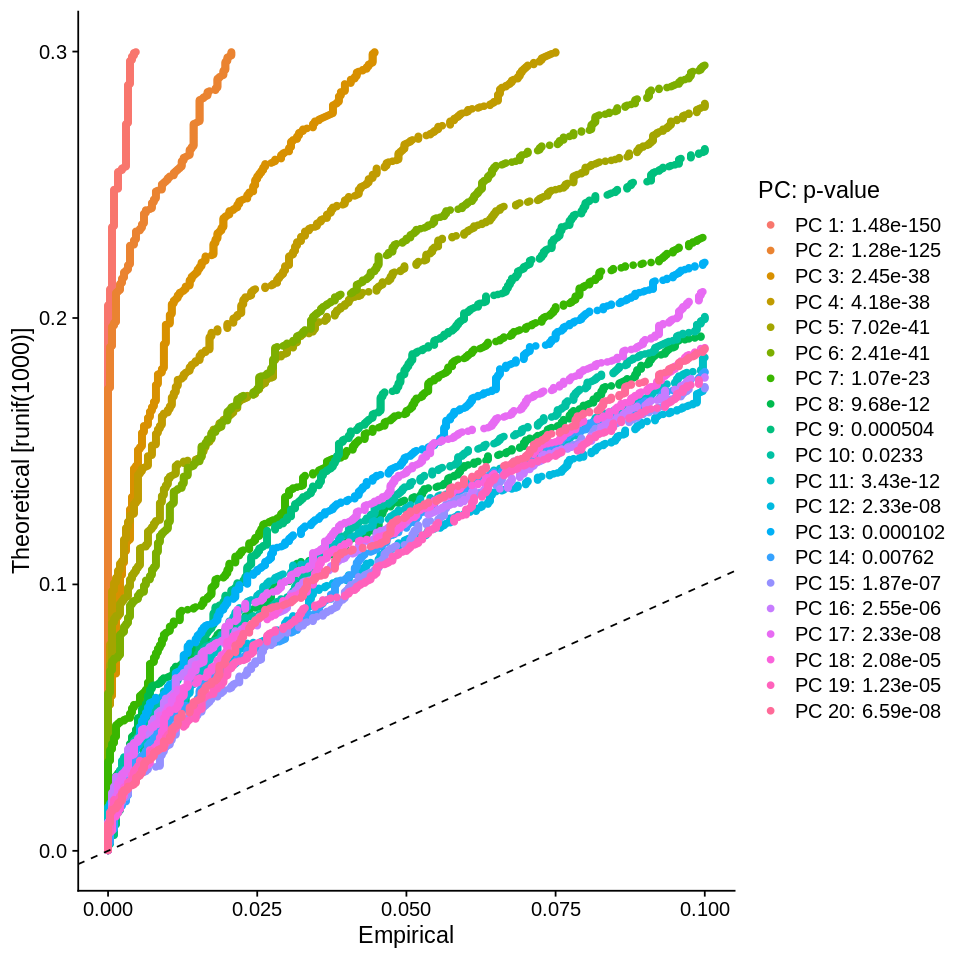

In [34]:
JackStrawPlot(normal2, dims = 1:20)

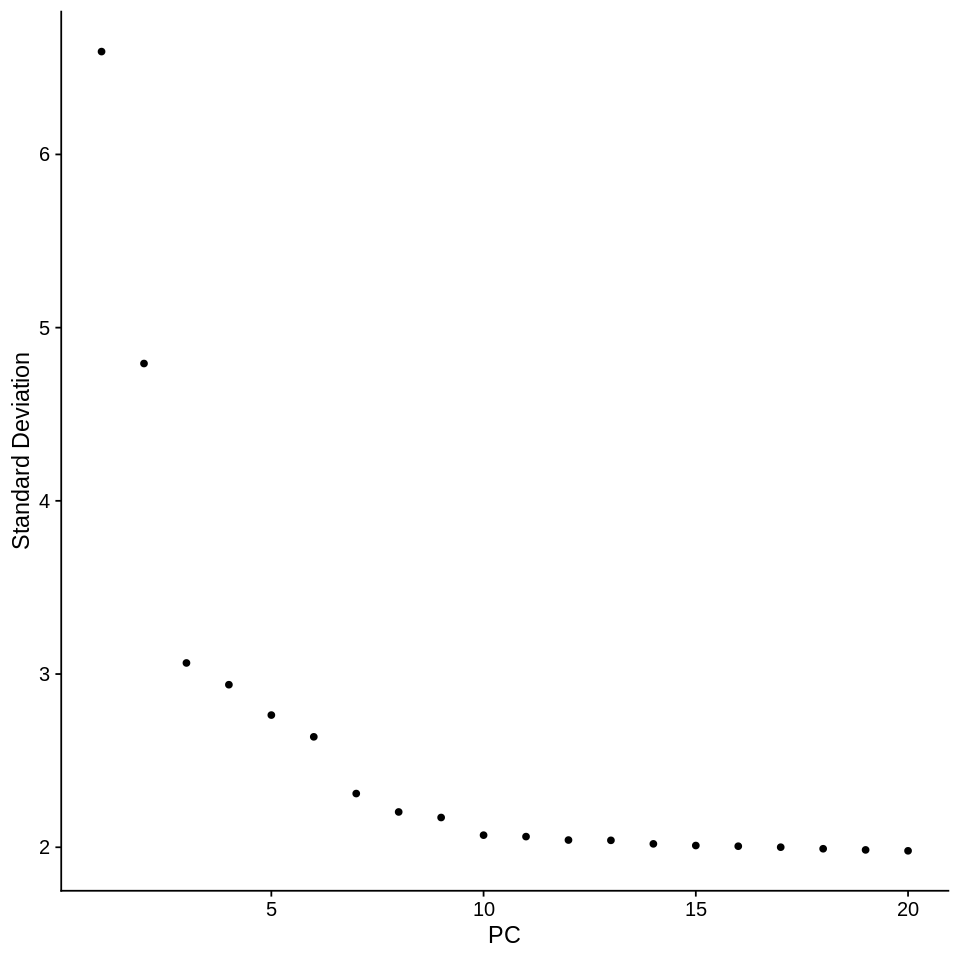

In [35]:
ElbowPlot(normal2)

In [36]:
normal2 <- FindNeighbors(normal2, dims = 1:10)
normal2 <- FindClusters(normal2, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2448
Number of edges: 88848

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7909
Number of communities: 11
Elapsed time: 0 seconds


In [37]:
normal2 <- RunUMAP(normal2, dims = 1:10)

13:58:43 UMAP embedding parameters a = 0.9922 b = 1.112

13:58:43 Read 2448 rows and found 10 numeric columns

13:58:43 Using Annoy for neighbor search, n_neighbors = 30

13:58:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:58:43 Writing NN index file to temp file /tmp/RtmpX3lwol/file82c5f5c4772a4

13:58:43 Searching Annoy index using 1 thread, search_k = 3000

13:58:44 Annoy recall = 100%

13:58:44 Commencing smooth kNN distance calibration using 1 thread

13:58:44 Initializing from normalized Laplacian + noise

13:58:45 Commencing optimization for 500 epochs, with 99826 positive edges

13:58:47 Optimization finished



In [38]:
options(repr.plot.height=8,repr.plot.width=8)

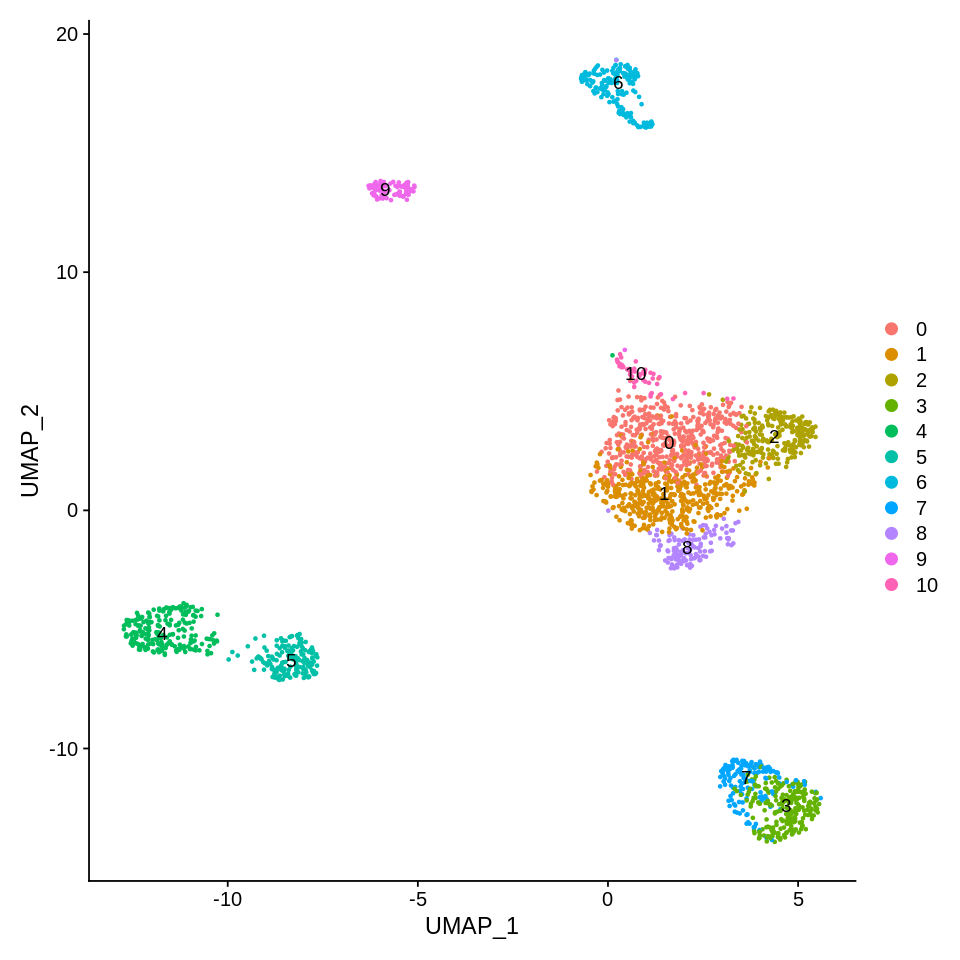

In [39]:
DimPlot(normal2, reduction = "umap",label=T)

In [40]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



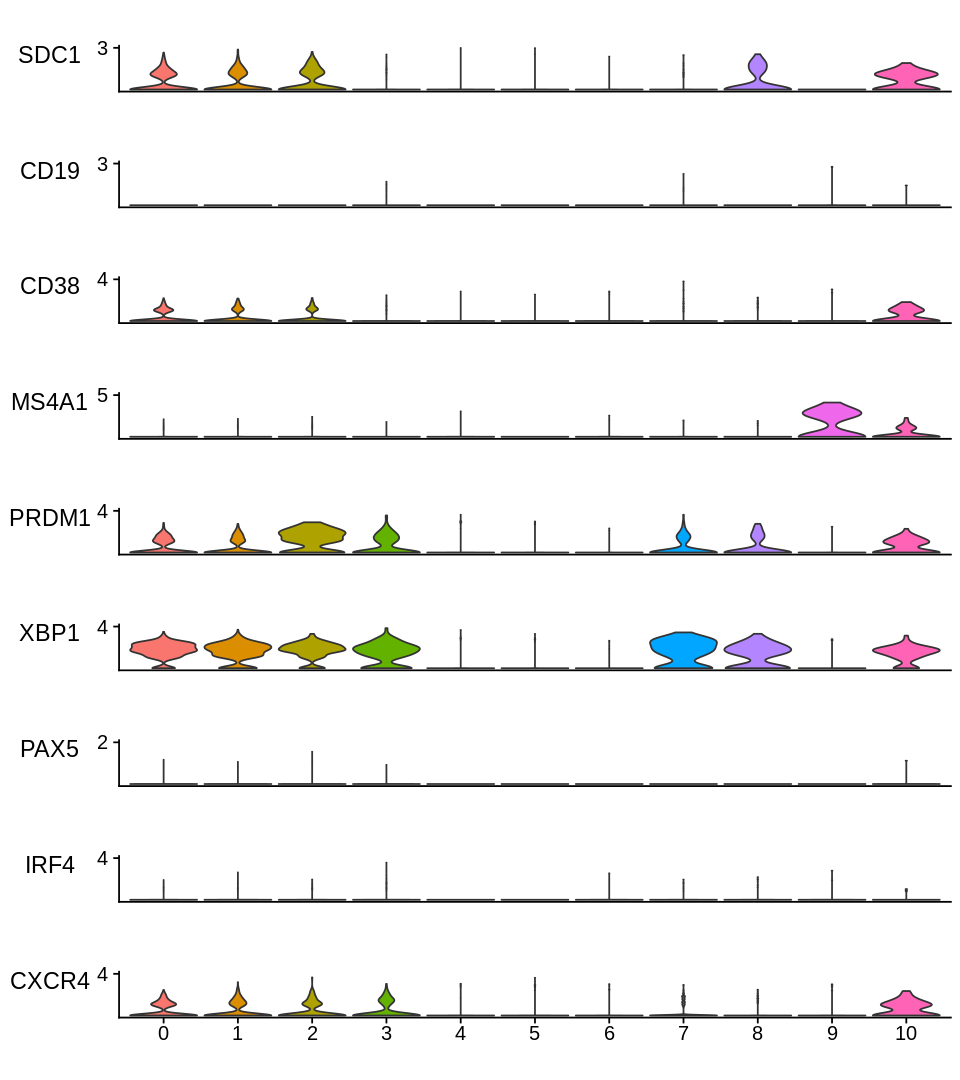

In [41]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



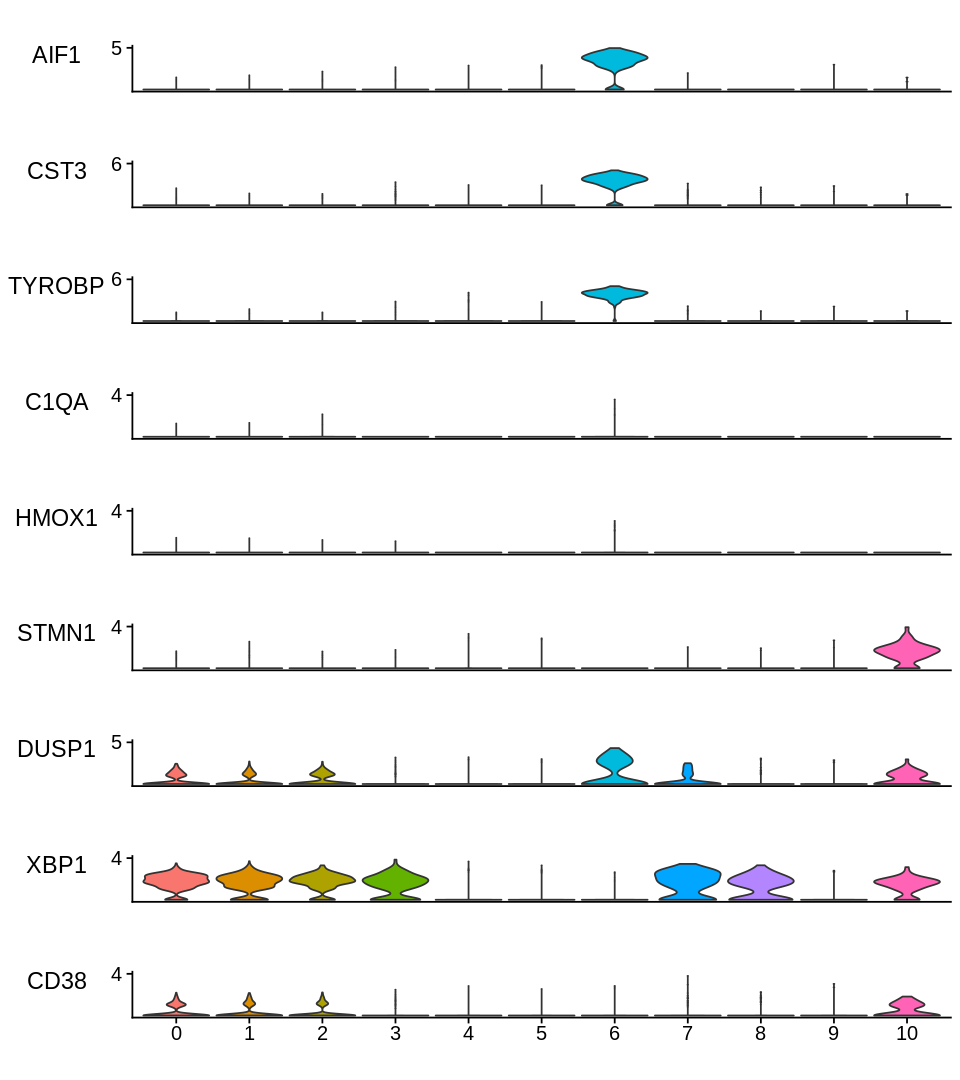

In [42]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [43]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



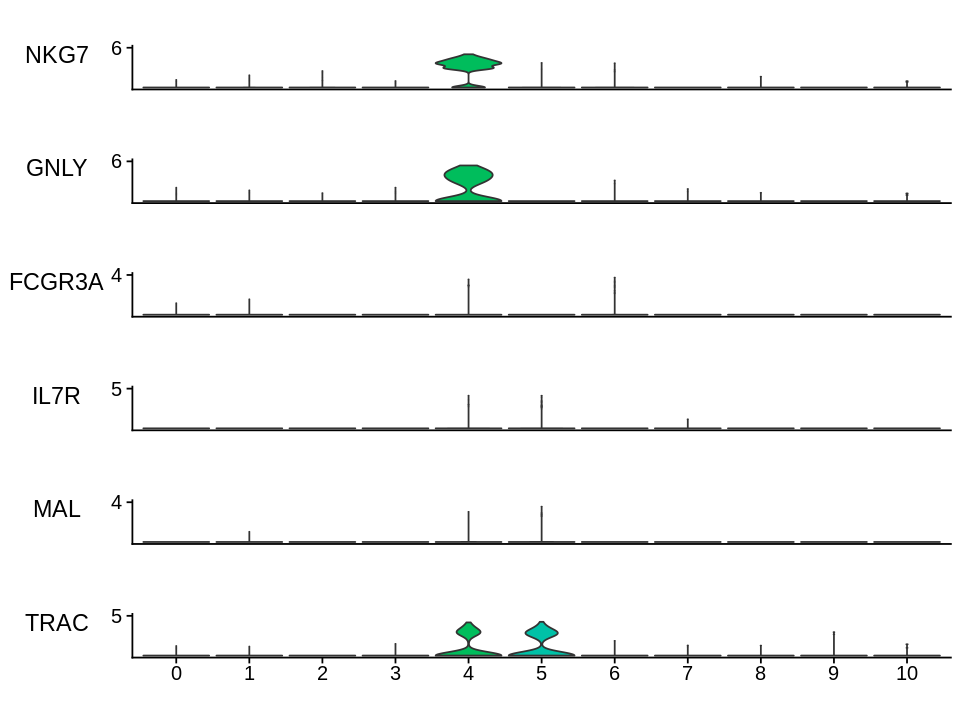

In [44]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



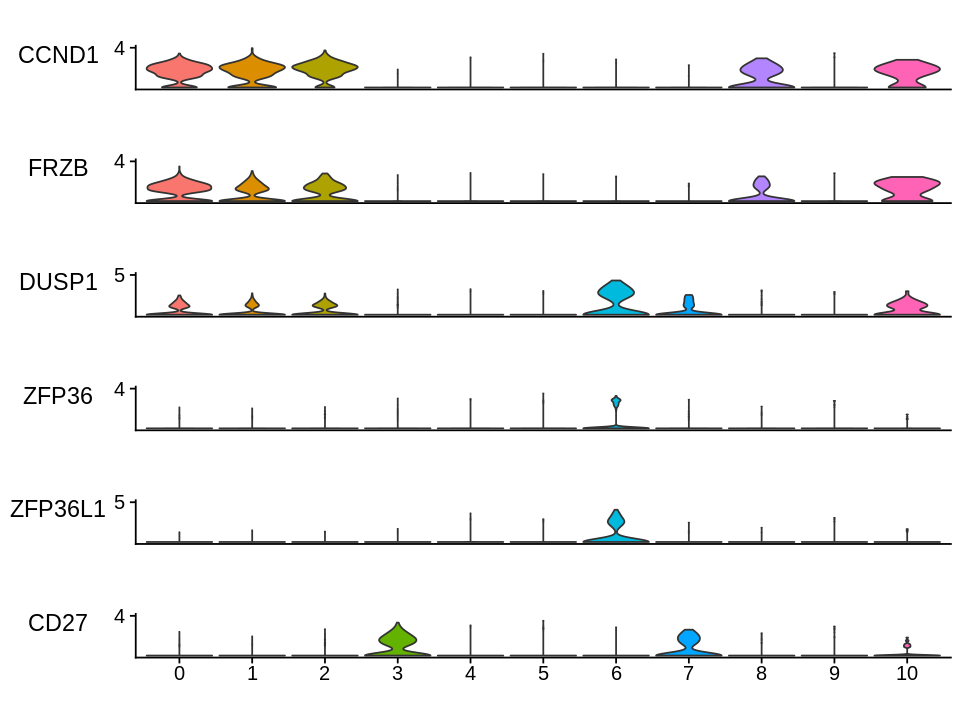

In [45]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [46]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




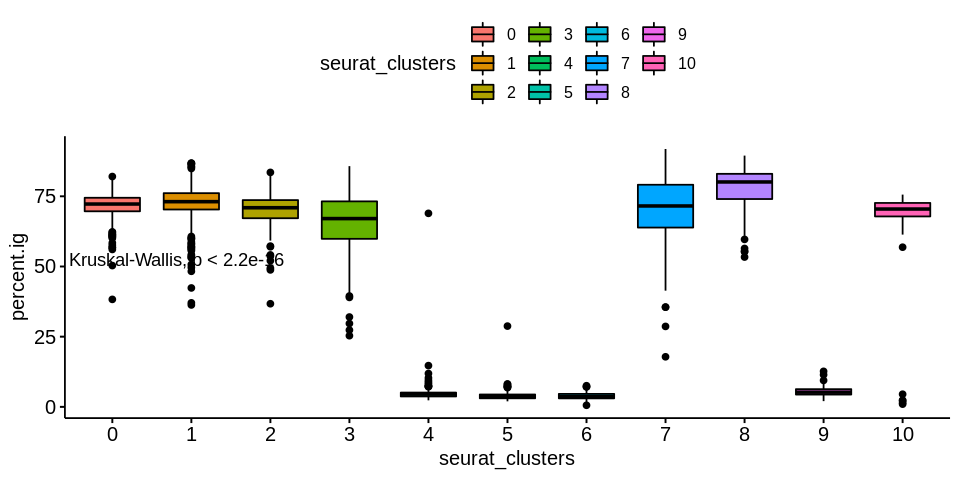

In [47]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [48]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.824791e-77,0.8894446,0.711,0.248,3.635506e-73,0,FRZB
4.472931e-66,0.8145331,0.752,0.300,5.756662e-62,0,RP5-887A10.1
1.611017e-64,0.7883184,0.854,0.376,2.073379e-60,0,CCND1
1.158506e-60,0.8671548,1.000,1.000,1.490997e-56,0,IGLC2
3.234158e-48,0.7970856,1.000,0.999,4.162362e-44,0,IGHG3
2.794899e-70,0.8626980,1.000,1.000,3.597035e-66,1,IGLC2
8.660625e-62,0.8445030,1.000,0.999,1.114622e-57,1,IGHG3
1.010478e-55,0.7214022,1.000,0.944,1.300485e-51,1,IGHG4
1.140180e-46,0.7796850,0.787,0.399,1.467412e-42,1,CCND1


In [49]:
options(repr.plot.height=10,repr.plot.width=10)

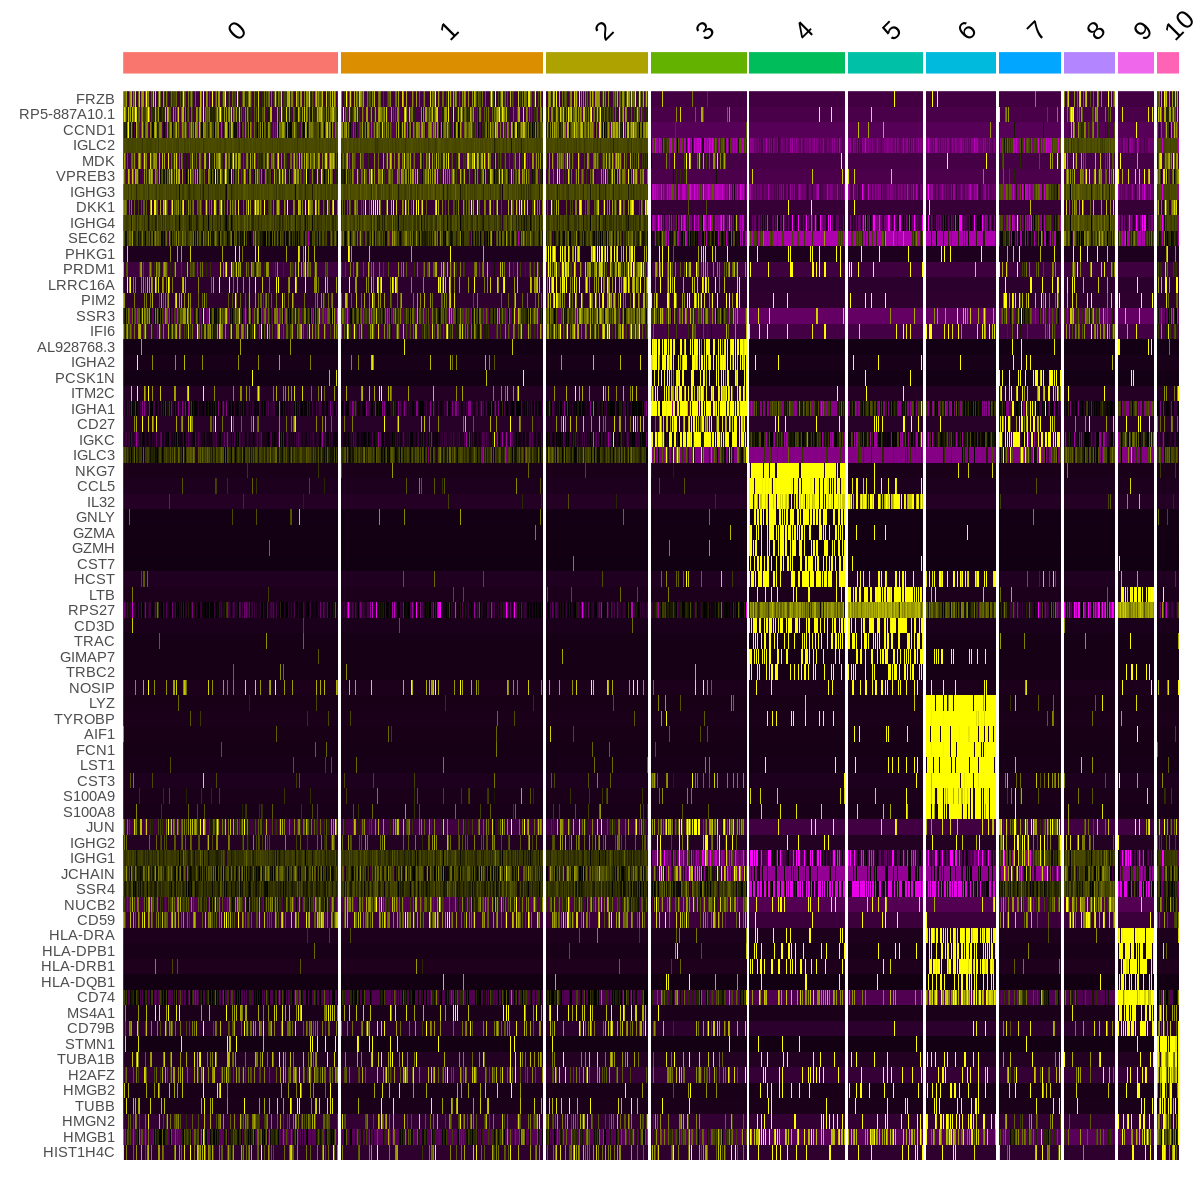

In [50]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [51]:
library("Seurat")
library("SingleR")

In [52]:
counts<-normal2@assays$RNA@counts
clusters<-normal2@meta.data$seurat_clusters
ann=normal2@meta.data$orig.ident

In [53]:
singler = CreateSinglerObject(counts, annot = ann, "normal",
  species = "Human", citation = "",
  ref.list = list(), variable.genes = "de",
  fine.tune = F, do.signatures = T, clusters = clusters, do.main.types = T,
  reduce.file.size = T, numCores = 1)

[1] "Dimensions of counts data: 12870x2448"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:2587"
[1] "Number of cells: 2448"
[1] "Number of DE genes:2587"
[1] "Number of clusters: 11"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:2006"
[1] "Number of cells: 2448"
[1] "Number of DE genes:2006"
[1] "Number of clusters: 11"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:2518"
[1] "Number of cells: 2448"
[1] "Number of DE genes:2518"
[1] "Number of clusters: 11"
[1] "Annotating data with Blueprint_Encode (Main types)..."
[1] "Number of DE genes:2053"
[1] "Number of cells: 2448"
[1] "Number of DE genes:2053"
[1] "Number of clusters: 11"


In [54]:
singler$seurat = normal
singler$meta.data$xy = normal2@reductions$umap@cell.embeddings
clusterAnn=singler$singler[[2]]$SingleR.clusters.main$labels
clusterAnn

0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,CD8+ T-cells
5,CD4+ T-cells
6,Monocytes
7,B-cells
8,B-cells
9,B-cells
10,B-cells


In [55]:
clusterAnn<-as.data.frame(clusterAnn)
clusterAnn

,V1
,<chr>
0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,CD8+ T-cells
5,CD4+ T-cells
6,Monocytes
7,B-cells
8,B-cells


In [56]:
type<-as.data.frame(singler$other)
type

,singler$other
,<chr>
AAACCTGAGTTTAGGA-1,B cells
AAACCTGCAAGCGTAG-1,B cells
AAACCTGCACCGTTGG-1,CD14+ Monocytes
AAACCTGCACCTGGTG-1,B cells
AAACCTGGTCTGCCAG-1,B cells
AAACGGGAGATGCCTT-1,B cells
AAACGGGAGCTGAACG-1,B cells
AAACGGGAGGGCTTGA-1,CD14+ Monocytes
AAACGGGCAAGTAATG-1,B cells


In [57]:
count<-table(type)
count

type
          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
             1369               245               268               186 
  Dendritic cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
               62               111               142                65 

In [58]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [87]:
plasma<-subset(normal2,ident=c(0,1,2,3,7,8,10))

In [88]:
options(repr.plot.height=8,repr.plot.width=8)

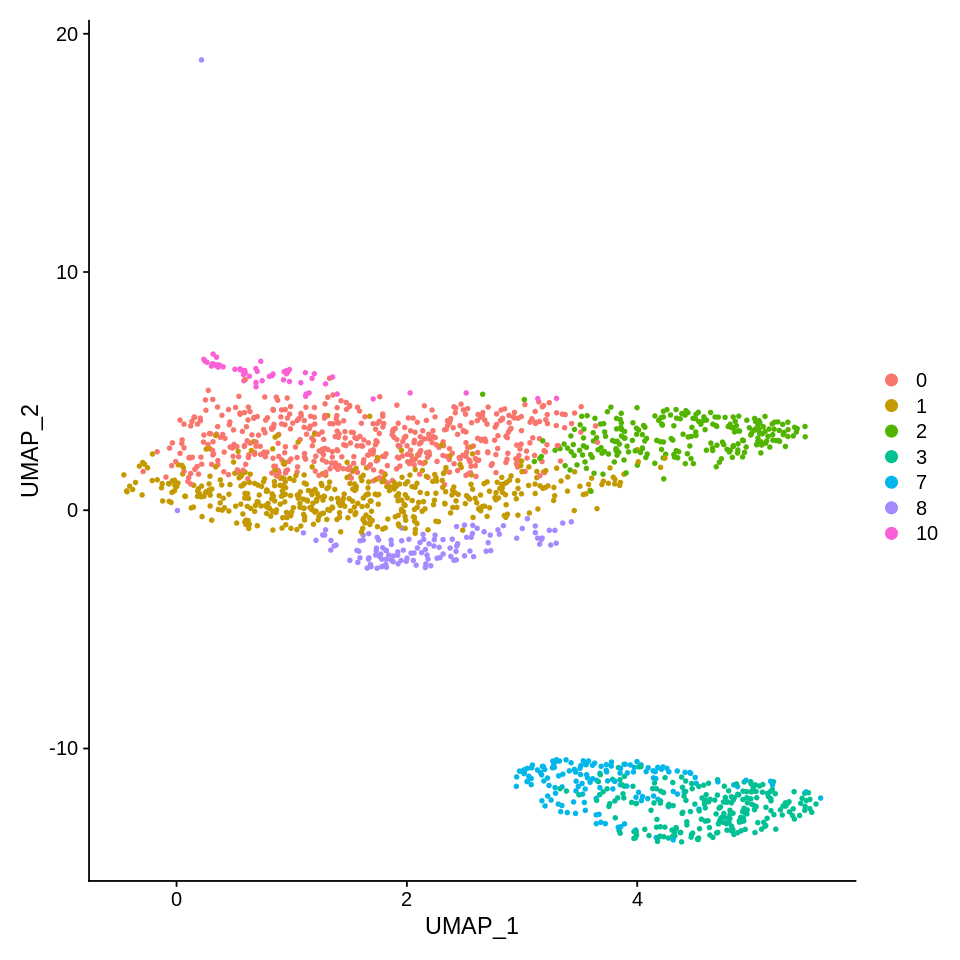

In [89]:
DimPlot(plasma, reduction = "umap")

In [90]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 7

Calculating cluster 8

Calculating cluster 10



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
6.282495e-32,0.5796072,0.711,0.372,8.085571e-28,0,FRZB
1.030010e-24,0.4385238,0.980,0.798,1.325623e-20,0,ITM2B
1.145668e-23,0.4869259,0.752,0.446,1.474474e-19,0,RP5-887A10.1
4.474522e-20,0.4527335,0.695,0.433,5.758710e-16,0,MDK
7.267144e-19,0.3855038,0.854,0.558,9.352814e-15,0,CCND1
9.313013e-19,0.4040878,0.594,0.329,1.198585e-14,0,CADM1
6.925242e-17,0.4073073,0.299,0.128,8.912786e-13,0,PHLDA1
2.058953e-16,0.3788945,0.756,0.491,2.649872e-12,0,VPREB3
3.939295e-16,0.4336805,0.537,0.306,5.069873e-12,0,DKK1


In [91]:
options(repr.plot.height=8,repr.plot.width=8)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



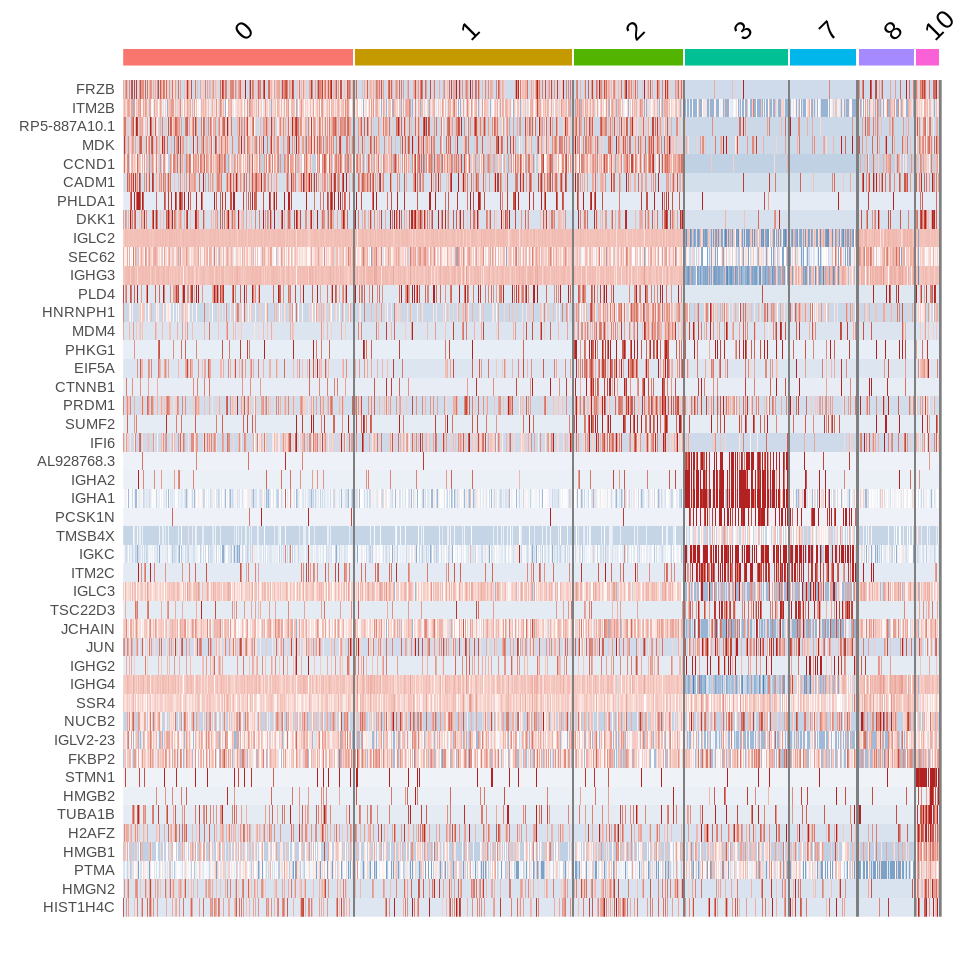

In [92]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [ ]:
save(plasma,file="0710-MGUSPC2-plasma.Rda")

In [94]:
plasma

An object of class Seurat 
12870 features across 1789 samples within 1 assay 
Active assay: RNA (12870 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [95]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



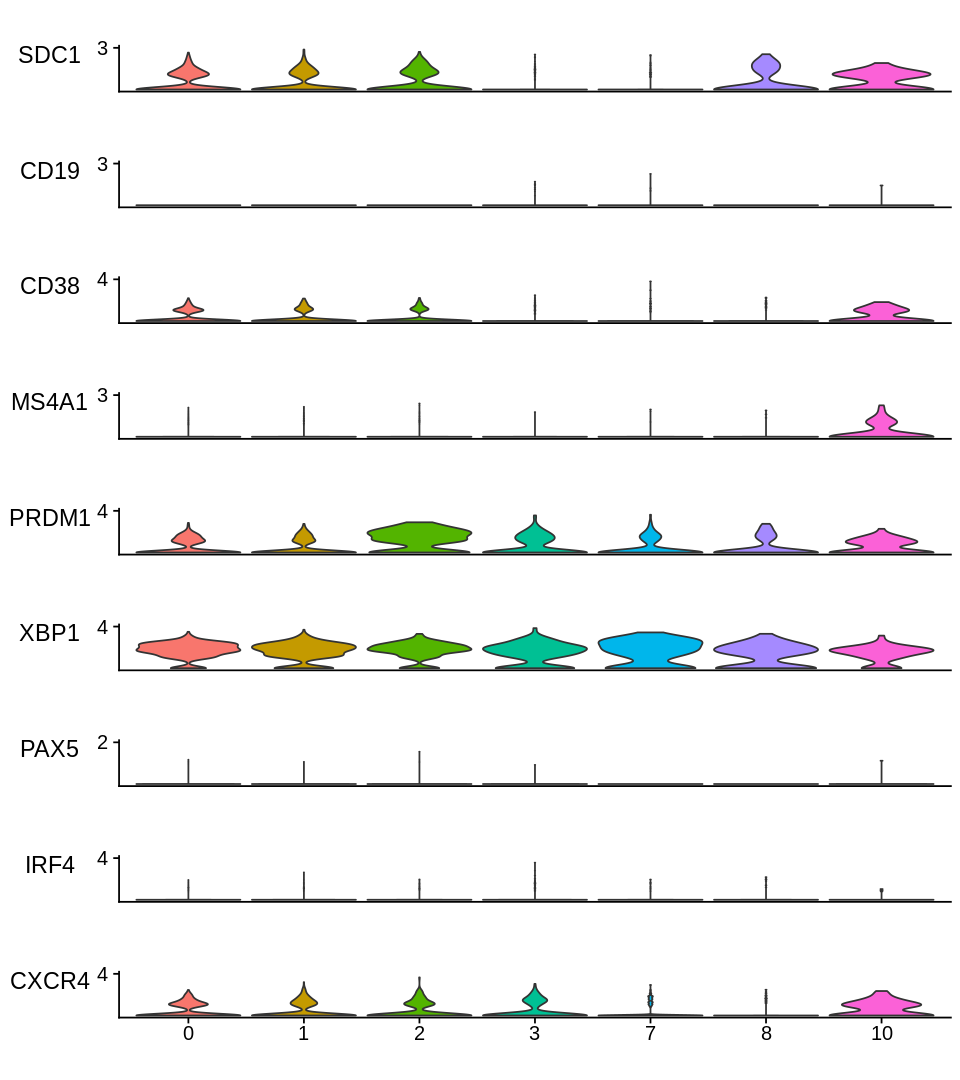

In [96]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



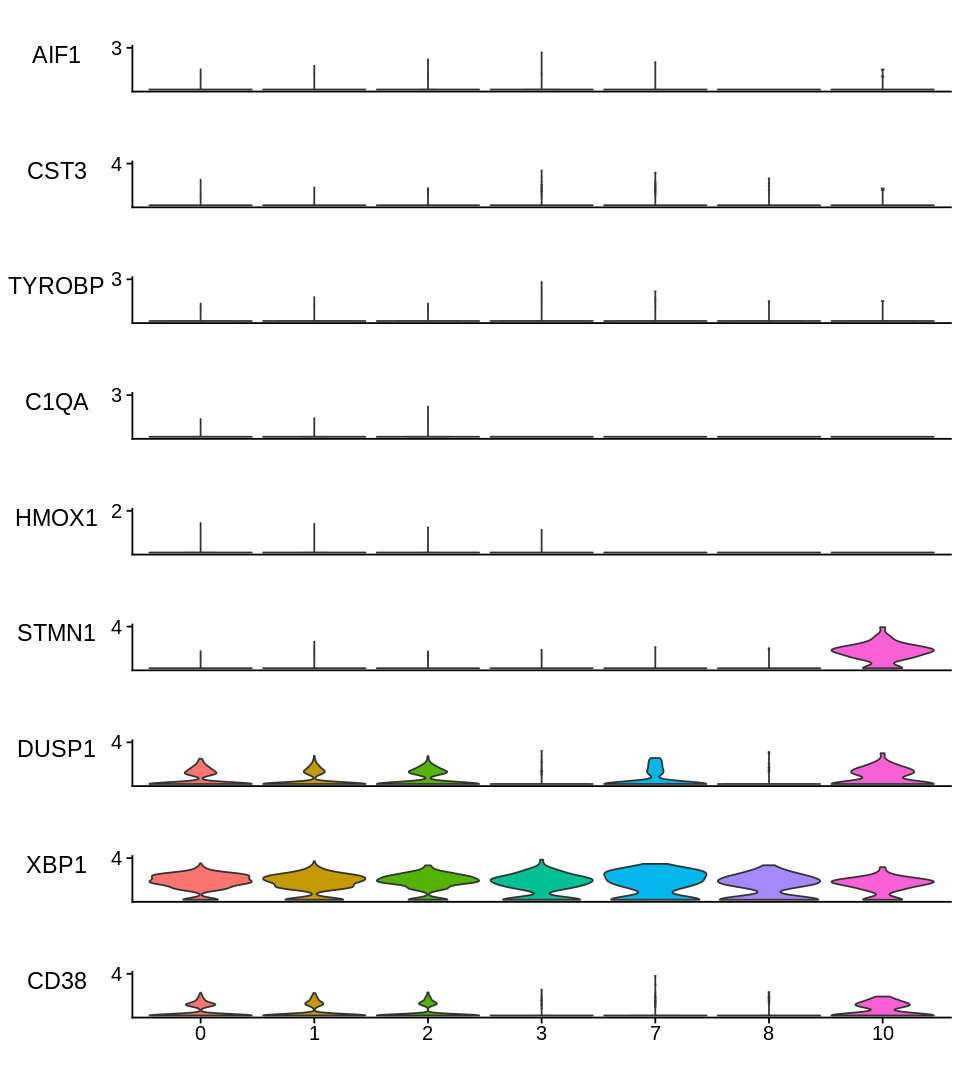

In [97]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [98]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



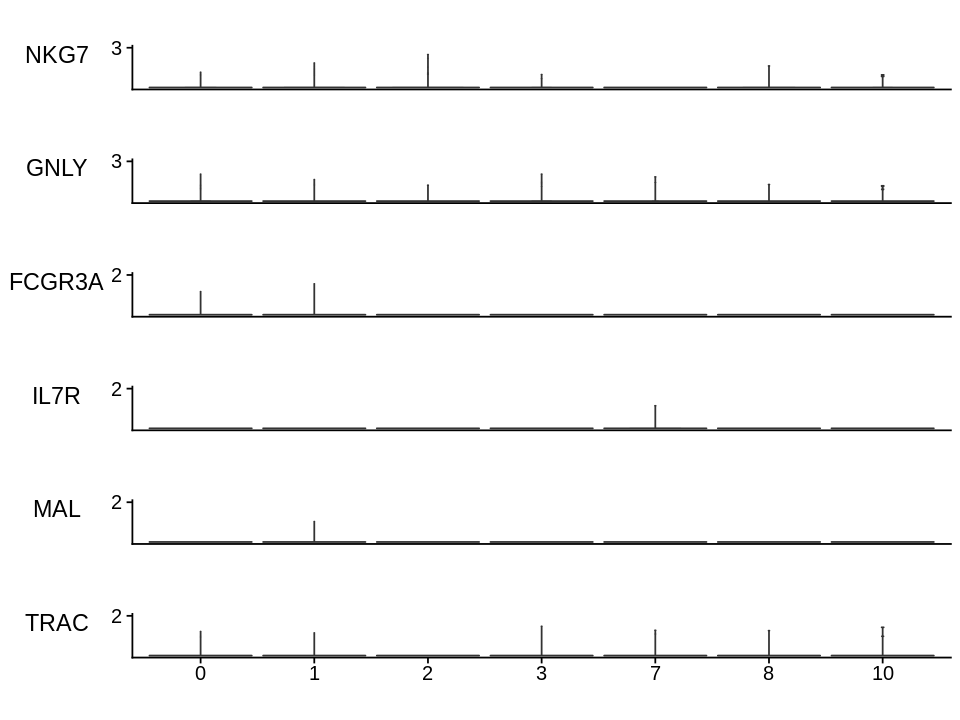

In [99]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



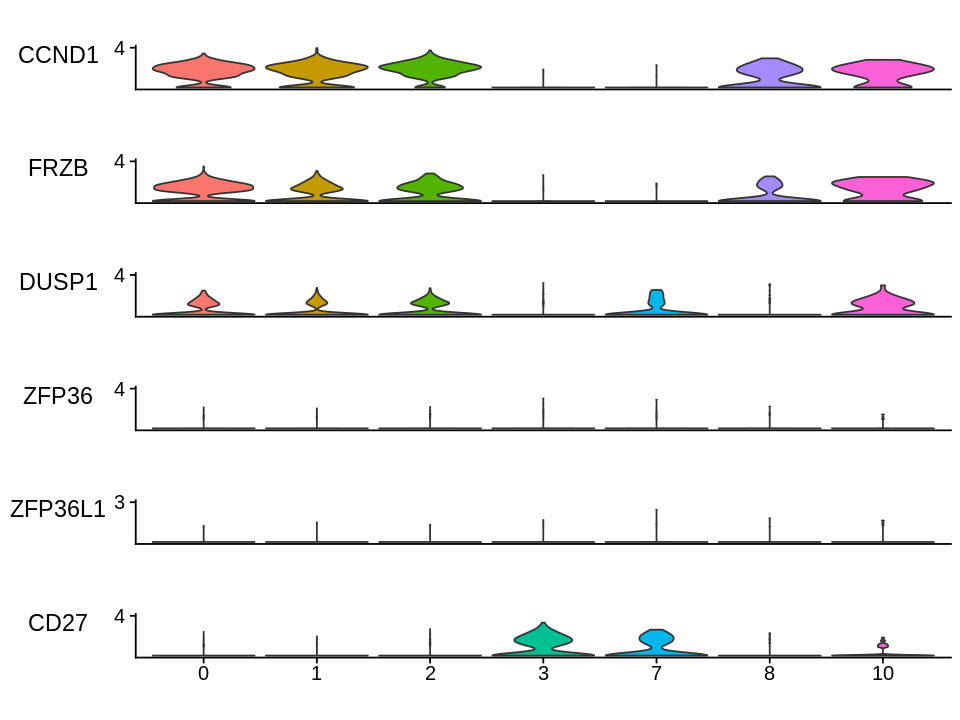

In [100]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =plasma, features = features)